# Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import xgboost as xgb
from xgboost import plot_importance as xgb_plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor

# EDA

In [ ]:
df = pd.read_csv('emisia-sample_dataset_for_msc.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values(by='datetime', inplace=True)
print(df.head())
print(df.info())

             datetime  mileage_km  speed_km_h  elevation_m  fuel_volume_lit  \
0 2022-06-01 00:00:18   284286.02           0          318           254.31   
1 2022-06-01 00:00:30   284286.02           0          318           252.17   
2 2022-06-01 00:01:02         NaN           0          318           252.87   
3 2022-06-01 00:02:00         NaN           0          318           253.94   
4 2022-06-01 00:03:30         NaN           0          318           252.49   

   gross_vehicle_weight_kg  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
<class 'pandas.core.frame.DataFrame'>
Index: 49020 entries, 0 to 49019
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   datetime                 49020 non-null  datetime64[ns]
 1   mileage_km               27815 non-null  float64       
 2  

In [ ]:
df['fuel_volume_lit'] = df['fuel_volume_lit'].interpolate(method='linear')

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

datetime                       0
mileage_km                 21205
speed_km_h                     0
elevation_m                    0
fuel_volume_lit                0
gross_vehicle_weight_kg    31375
dtype: int64


In [ ]:
def plot_series(df, x_col, y_col, title, xlabel, ylabel, color, grid=False, legend=False):
    plt.figure(figsize=(10, 4))
    plt.plot(df[x_col], df[y_col], label=ylabel, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if grid:
        plt.grid(True)
    if legend:
        plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

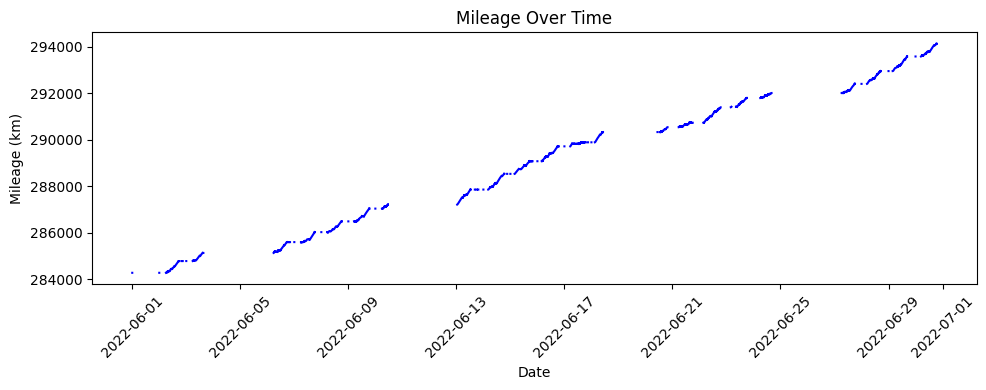

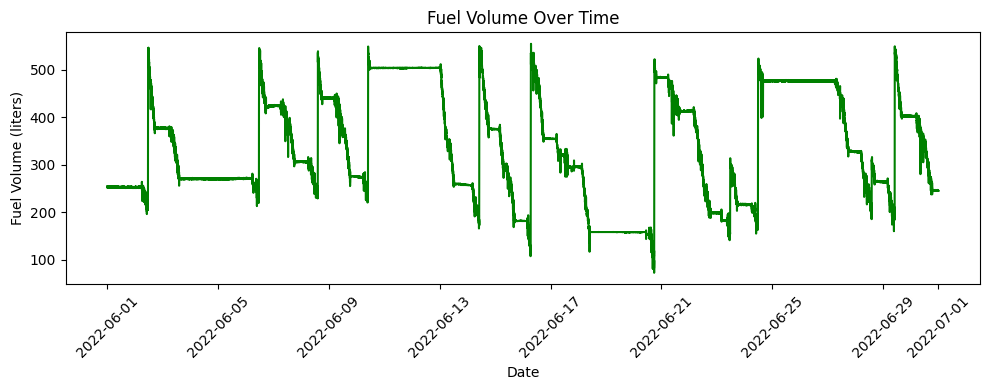

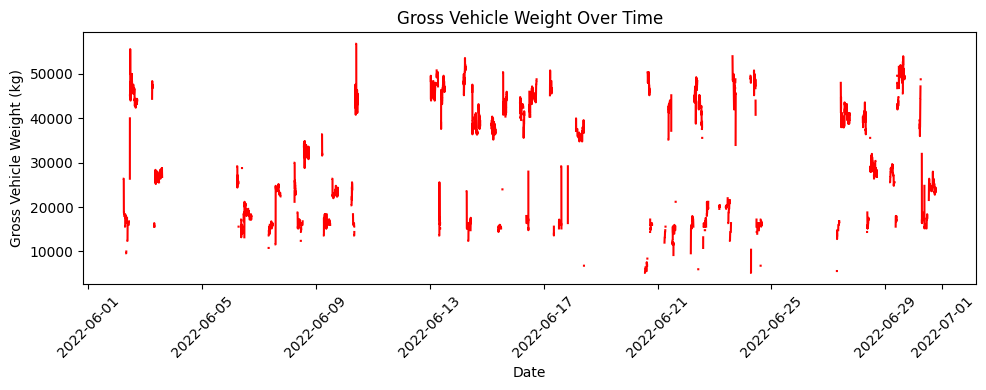

In [ ]:
plot_series(df, 'datetime', 'mileage_km', 'Mileage Over Time', 'Date', 'Mileage (km)', 'blue')
plot_series(df, 'datetime', 'fuel_volume_lit', 'Fuel Volume Over Time', 'Date', 'Fuel Volume (liters)', 'green')
plot_series(df, 'datetime', 'gross_vehicle_weight_kg', 'Gross Vehicle Weight Over Time', 'Date', 'Gross Vehicle Weight (kg)', 'red')

**Many missing values on mileage apperas to be when the truck is stationary (possible solution: fill the missing values with the previous mileage)**

In [ ]:
missing_mileage = df[df['mileage_km'].isnull()]

# Check if speed_km_h is 0 for these rows
speed_zero_missing_mileage = missing_mileage[missing_mileage['speed_km_h'] == 0]

# Calculate the percentage of missing mileage where speed is 0
percentage_speed_zero_missing = len(speed_zero_missing_mileage) / len(missing_mileage) * 100
print(f"Percentage of missing mileage where speed is 0: {percentage_speed_zero_missing:.2f}%")

df['mileage_km'] = df['mileage_km'].fillna(method='ffill')

Percentage of missing mileage where speed is 0: 99.86%


<ipython-input-55-4210a08e8e0f>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['mileage_km'] = df['mileage_km'].fillna(method='ffill')


In [ ]:
df['distance_covered_km'] = df['mileage_km'].diff().fillna(0)
df['cumulative_distance_covered'] = df['distance_covered_km'].cumsum()
df['smoothed_fuel'] = df['fuel_volume_lit'].rolling(window=15, min_periods=1).mean()

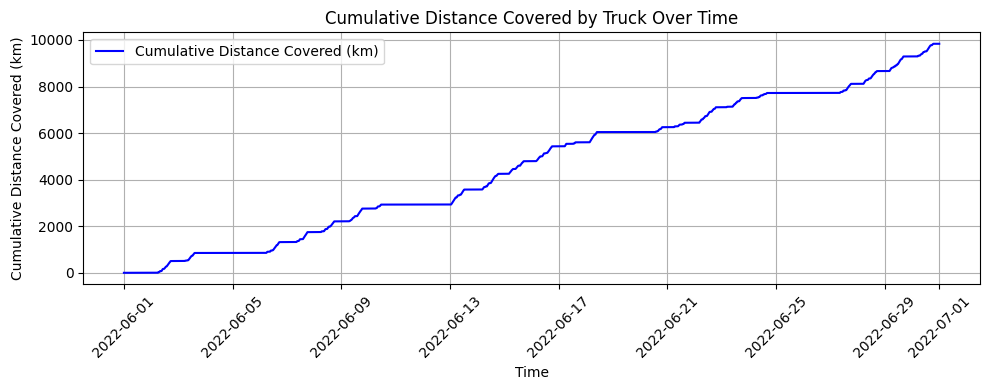

In [ ]:
plot_series(df, 'datetime', 'cumulative_distance_covered', 'Cumulative Distance Covered by Truck Over Time', 'Time', 'Cumulative Distance Covered (km)', 'blue', grid=True, legend=True)


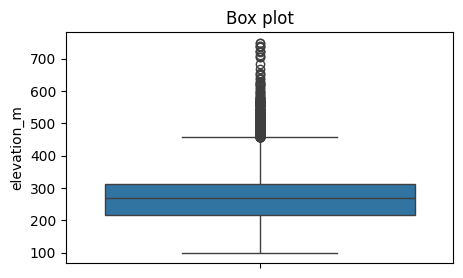

In [ ]:
df=df[df['elevation_m'] <10000]
plt.figure(figsize=(5, 3))
sns.boxplot(y=df['elevation_m'])
plt.title('Box plot')
plt.xlabel('')
plt.show()

# Truck total distance for 10 days

<ipython-input-59-412e8095cc22>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['distance_covered_km'] = filtered_df['mileage_km'].diff().fillna(0)
<ipython-input-59-412e8095cc22>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cumulative_distance_covered'] = filtered_df['distance_covered_km'].cumsum()


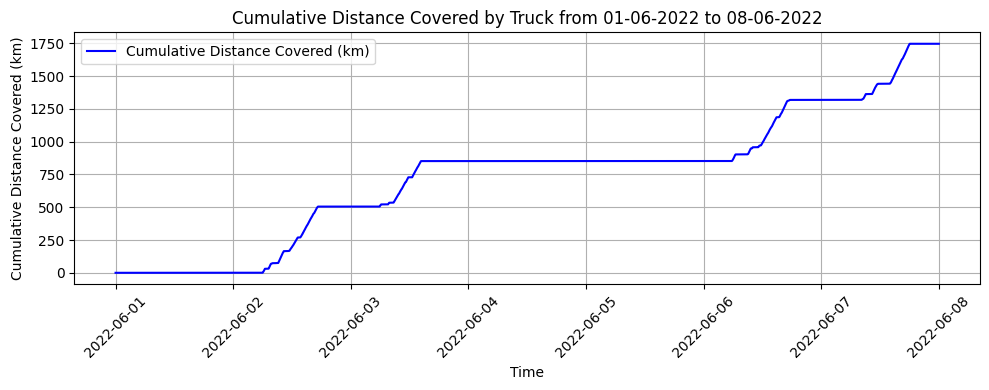

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

# Filter the data to only include entries from 01-06-22 to 11-06-22
start_date = '2022-06-01'
end_date = '2022-06-08'

# Filter the dataframe for the date range
filtered_df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

# Calculate the cumulative distance covered for the filtered data
filtered_df['distance_covered_km'] = filtered_df['mileage_km'].diff().fillna(0)
filtered_df['cumulative_distance_covered'] = filtered_df['distance_covered_km'].cumsum()
plot_series(filtered_df, 'datetime', 'cumulative_distance_covered', 'Cumulative Distance Covered by Truck from 01-06-2022 to 08-06-2022', 'Time', 'Cumulative Distance Covered (km)', 'blue', grid=True, legend=True)

# Trend analysis for random date

<ipython-input-60-dea61acfd35d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['distance_covered_km'] = filtered_df['mileage_km'].diff().fillna(0)
<ipython-input-60-dea61acfd35d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cumulative_distance_covered'] = filtered_df['distance_covered_km'].cumsum()


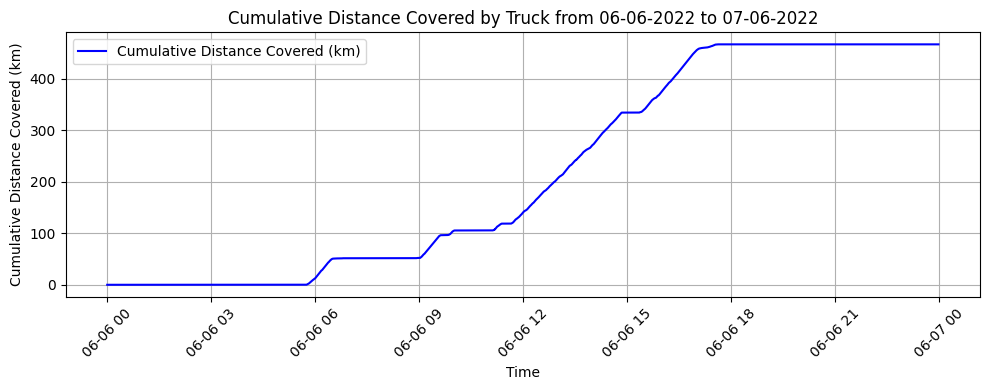

In [ ]:
start_date = '2022-06-06'
end_date = '2022-06-07'


filtered_df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

filtered_df['distance_covered_km'] = filtered_df['mileage_km'].diff().fillna(0)
filtered_df['cumulative_distance_covered'] = filtered_df['distance_covered_km'].cumsum()

plot_series(filtered_df, 'datetime', 'cumulative_distance_covered', 'Cumulative Distance Covered by Truck from 06-06-2022 to 07-06-2022', 'Time', 'Cumulative Distance Covered (km)', 'blue', grid=True, legend=True)


## Speed

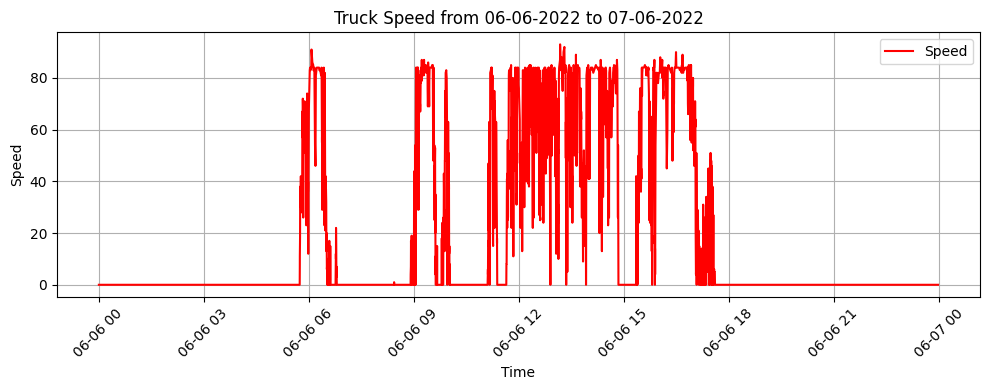

In [ ]:
plot_series(filtered_df, 'datetime', 'speed_km_h', 'Truck Speed from 06-06-2022 to 07-06-2022', 'Time', 'Speed', 'red', grid=True, legend=True)

## Fuel

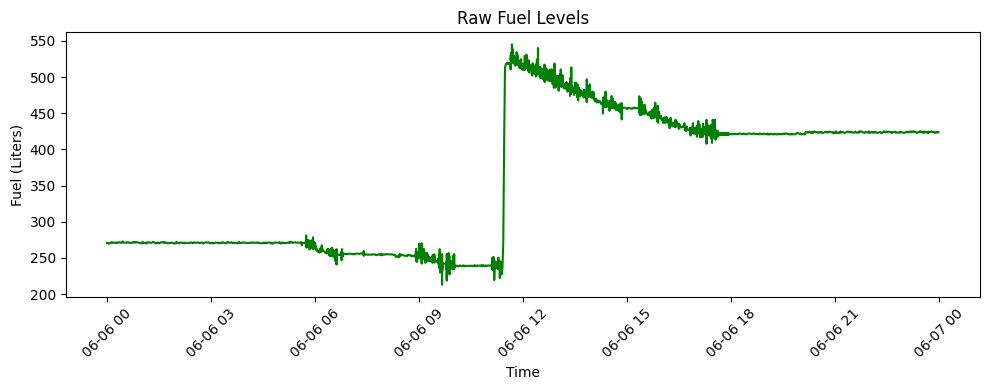

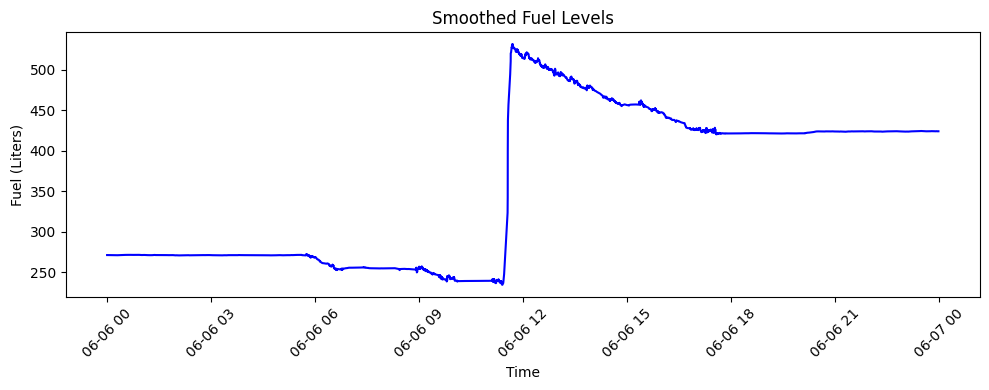

In [ ]:
plot_series(filtered_df, 'datetime', 'fuel_volume_lit', 'Raw Fuel Levels', 'Time', 'Fuel (Liters)', 'green')
plot_series(filtered_df, 'datetime', 'smoothed_fuel', 'Smoothed Fuel Levels', 'Time', 'Fuel (Liters)', 'blue')

## Weight

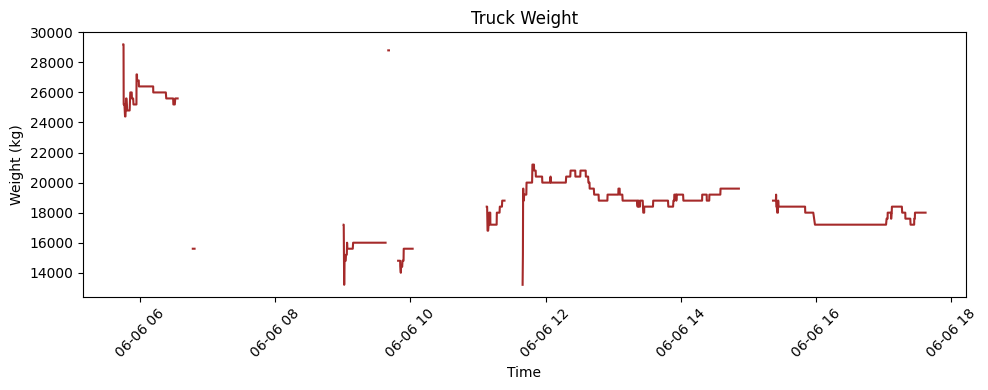

In [ ]:
plot_series(filtered_df, 'datetime', 'gross_vehicle_weight_kg', 'Truck Weight', 'Time', 'Weight (kg)', 'brown')

# Preprocessing

In [ ]:
def remove_consecutive_nulls(df, feature, threshold):
    """
    Removes consecutive rows where the specified feature has null values,
    if the number of consecutive nulls meets or exceeds the threshold.

    Parameters:
    - df: Pandas DataFrame
    - feature: Column name (string) to check for consecutive nulls
    - threshold: Minimum number of consecutive nulls required for removal

    Returns:
    - A new DataFrame with consecutive null rows removed
    """
    df = df.copy()  # Avoid modifying the original DataFrame

    # Create a mask for null values
    null_mask = df[feature].isnull()

    # Identify consecutive groups of null values
    df["group"] = (null_mask != null_mask.shift()).cumsum()  # Assign group numbers

    # Count only null values per group
    null_group_counts = df[null_mask].groupby("group")[feature].transform("size")


    # Remove rows where the entire group is null and meets the threshold
    filtered_df = df[~((null_mask) & (null_group_counts >= threshold))].drop(columns=["group"])

    return filtered_df

In [ ]:
df_cleaned = remove_consecutive_nulls(df, 'gross_vehicle_weight_kg', 200)

<ipython-input-64-d9c62693deca>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[~((null_mask) & (null_group_counts >= threshold))].drop(columns=["group"])


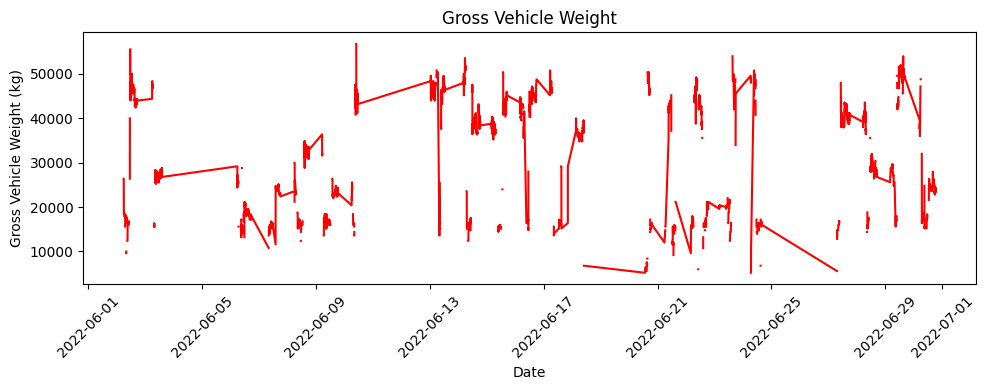

In [ ]:
plot_series(df_cleaned, 'datetime', 'gross_vehicle_weight_kg', 'Gross Vehicle Weight', 'Date', 'Gross Vehicle Weight (kg)', 'red')

## Interpolation

In [ ]:
df = df.reset_index(drop=True)

# Linear Interpolation - Fills Missing Values
df['linear_interp'] = df['gross_vehicle_weight_kg'].interpolate(method='linear')

# Get valid (non-missing) data points for polynomial interpolation
valid_data = df.dropna(subset=['gross_vehicle_weight_kg'])
x_valid = valid_data.index.to_numpy()  # Ensure x values are numeric
y_valid = valid_data['gross_vehicle_weight_kg'].to_numpy()

# Apply Polynomial Interpolation (Quadratic)
if len(x_valid) > 2:  # Need at least 3 points for quadratic interpolation
    poly_interp = interp1d(x_valid, y_valid, kind='quadratic', fill_value="extrapolate")
    df['poly_interp'] = poly_interp(df.index.to_numpy())

    # Fill only where data is missing
    df['poly_interp'] = df['gross_vehicle_weight_kg'].combine_first(df['poly_interp'])
else:
    df['poly_interp'] = df['linear_interp']  # Fallback to linear if not enough points

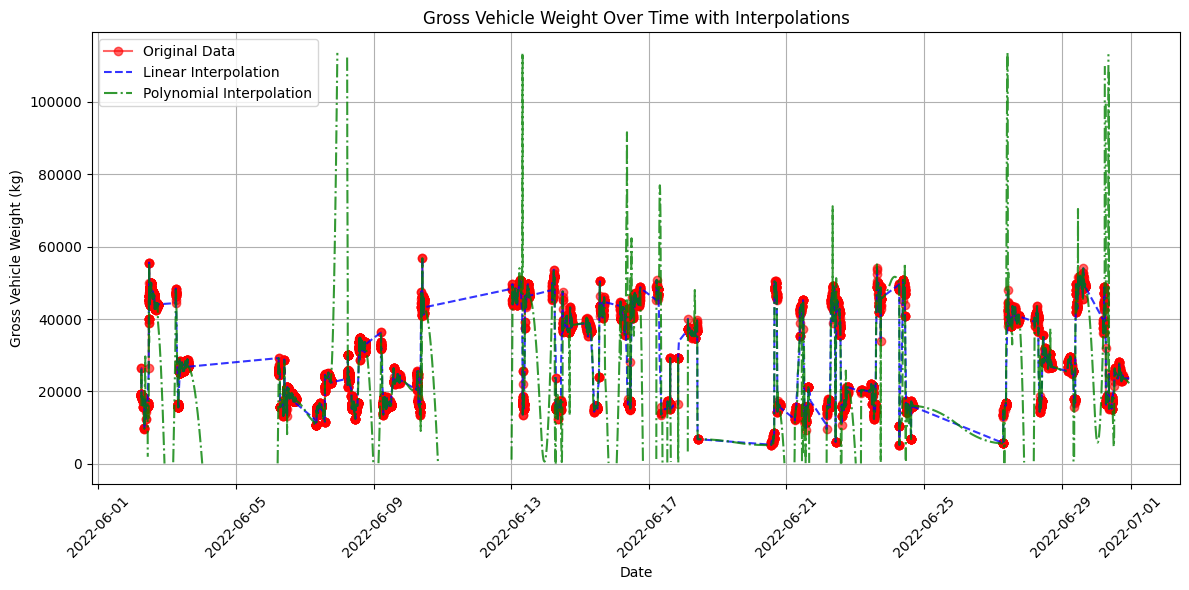

In [ ]:
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(df['datetime'], df['gross_vehicle_weight_kg'], 'o-', label='Original Data', color='red', alpha=0.6)

# Plot linear interpolation
plt.plot(df['datetime'], df['linear_interp'], '--', label='Linear Interpolation', color='blue', alpha=0.8)

# Plot polynomial interpolation
y_max = df['gross_vehicle_weight_kg'].max()
df['poly_interp_clipped'] = df['poly_interp'].where(df['poly_interp'].between(0, y_max * 2), np.nan)
plt.plot(df['datetime'], df['poly_interp_clipped'], '-.', label='Polynomial Interpolation', color='green', alpha=0.8)


# Formatting
plt.title('Gross Vehicle Weight Over Time with Interpolations')
plt.xlabel('Date')
plt.ylabel('Gross Vehicle Weight (kg)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Polynomial Intepolation causes extreme value out of the ordinary. So we will simply utilize Linear interpolation to predict our weights and further use for our experiments.**

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

df['speed_m_s'] = df['speed_km_h'] * (5 / 18)
df['speed_diff'] = df['speed_m_s'].diff()

df['time_diff'] = df['datetime'].diff().dt.total_seconds()

df['acceleration'] = df['speed_diff'] / df['time_diff']
df['acceleration'] = df['acceleration'].replace([np.inf, -np.inf], np.nan)
df['acceleration'] = df['acceleration'].fillna(0)

In [ ]:
df['elev_diff'] = df['elevation_m'].diff()

In [ ]:
df.to_csv("df_clean.csv",index=False)